---
title: Основная часть
format: 
  html:
    code-fold: true
toc: true
jupyter: python3
---

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

FORMAT = "jpg"
TEMP_DIR = "./temp/"


def show_image(image_path: str, fig_size: tuple[int, int]) -> None:
  fig = plt.figure(figsize=fig_size)
  ax = fig.add_subplot(111)
  img = Image.open(image_path)
  ax.imshow(img)
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  plt.show()

## Принципиальное отличие Kappa и Lambda

### Пример
От пользователей нашего сайта в больших количествах идут различные события:

1) клики
2) переходы по ссылкам
3) фокусировка на определенных элементах интерфейса
4) прочие события 

Бизнесу интересно в режиме реального времени анализировать эти события, например, смотреть на то как меняется количество кликов.

### Lambda-архитектура
Данная архитектура образована несколькими слоями и представлена на рисунке @fig-lambda-basic:

1. Distribution Layer - источник данных, обычно это шина сообщений, которая пополняется пользовательскими событиями
2. Batch Layer - пакетная обработка данных, в этом слое события заливаются в хранилище сырых данных и раз в определенный период времени запускается обработка имеющихся данных для получения точных значений агрегатов (например, количество пользовательских взаимодействий по каждому типу событий)
3. Speed Layer - потоковая обработка данных, в этом слое события обрабатываются по мере их появления (для данного примера это простое увеличение счетчика для каждого типа события)
4. Serving Layer - хранение агрегированных данных, к которым обращается аналитическая система или BI-инструмент

Batch Layer и Speed Layer реализуют одну и ту же логику. Batch-слой позволяет получить точные данные, а Speed-слой неплохую интерполяцию в промежутке между пересчетами Batch'ей. Полный пересчет агрегаций легко реализуется с помощью Batch-слоя.

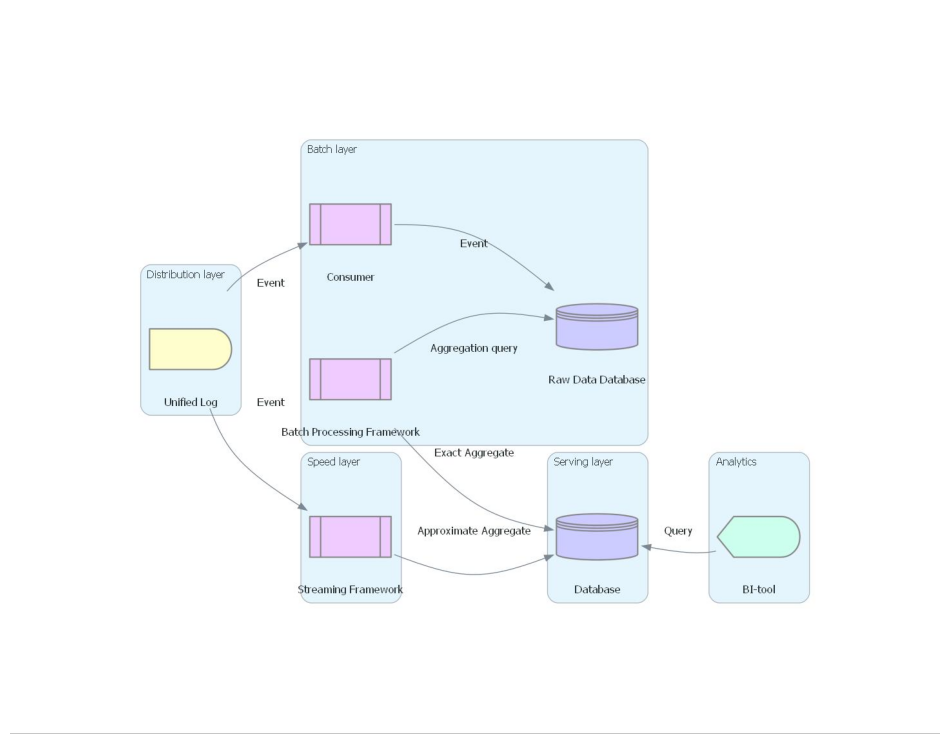

In [2]:
#| label: fig-lambda-basic
#| fig-cap: "Lambda Архитектура"
from diagrams import Diagram, Cluster, Edge
from diagrams.programming.flowchart import PredefinedProcess
from diagrams.programming.flowchart import Delay
from diagrams.programming.flowchart import Display
from diagrams.programming.flowchart import Database


filename = TEMP_DIR + "lambda-basic"

with Diagram("", show=False, direction="LR", filename=filename, outformat=FORMAT, curvestyle="curved"):
  with Cluster("Distribution layer", direction="LR"):
    unified_log = Delay("Unified Log")
  with Cluster("Speed layer", direction="LR"):
    streaming_framework = PredefinedProcess("Streaming Framework")
  with Cluster("Batch layer", direction="LR"):
    consumer = PredefinedProcess("Consumer")
    raw_data_db = Database("Raw Data Database")
    batch_framework = PredefinedProcess("Batch Processing Framework")
  with Cluster("Serving layer", direction="LR"):
    db = Database("Database")
  unified_log >> Edge(label="Event") >> streaming_framework
  unified_log >> Edge(label="Event") >> consumer
  streaming_framework >> Edge(label="Approximate Aggregate") >> db
  consumer >> Edge(label="Event") >> raw_data_db
  batch_framework >> Edge(label="Aggregation query") >> raw_data_db
  batch_framework >> Edge(label="Exact Aggregate") >> db
  with Cluster("Analytics", direction="LR"):
    bi = Display("BI-tool")
    db << Edge(label="Query") << bi

show_image(f"{filename}.{FORMAT}", (12, 10))

### Kappa-архитектура
Данная архитектура отличается от предыдущей отсутствием Batch-слоя и представлена на рисунке @fig-kappa-basic:

1. Distribution Layer - источник данных, обычно это шина сообщений, которая пополняется пользовательскими событиями
2. Speed Layer - потоковая обработка данных, в этом слое события обрабатываются по мере их появления (для данного примера это простое увеличение счетчика для каждого типа события)
3. Serving Layer - хранение агрегированных данных, к которым обращается аналитическая система или BI-инструмент

Полный пересчет возможен лишь частично, так как отсутствует полное хранение сырых данных. Пересчет происходит засчет повторного прогона событий из источника данных через Speed-слой.

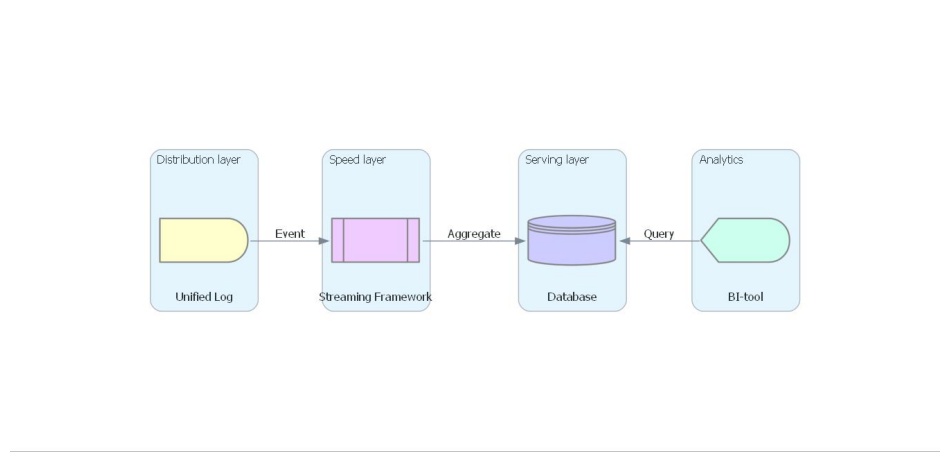

In [3]:
#| label: fig-kappa-basic
#| fig-cap: "Kappa Архитектура"
from diagrams import Diagram, Cluster, Edge
from diagrams.programming.flowchart import PredefinedProcess
from diagrams.programming.flowchart import Delay
from diagrams.programming.flowchart import Display
from diagrams.programming.flowchart import Database


filename = TEMP_DIR + "kappa-basic"

with Diagram("", show=False, direction="LR", filename=filename, outformat=FORMAT, curvestyle="ortho"):
  with Cluster("Distribution layer", direction="LR"):
    unified_log = Delay("Unified Log")
  with Cluster("Speed layer", direction="LR"):
    streaming_framework = PredefinedProcess("Streaming Framework")
  with Cluster("Serving layer", direction="LR"):
    db = Database("Database")
  unified_log >> Edge(label="Event") >> streaming_framework
  streaming_framework >> Edge(label="Aggregate") >> db
  with Cluster("Analytics", direction="LR"):
    bi = Display("BI-tool")
    db << Edge(label="Query") << bi

show_image(f"{filename}.{FORMAT}", (12, 6))

## Инструменты

От общих представлений о компонентах, из которых состоит Kappa-архитектура, перейдем к конкретным инструментам, которые позволяют реализовать её на практике.

Пример с реальными технологиями представлен на рисунке @fig-kappa-tools

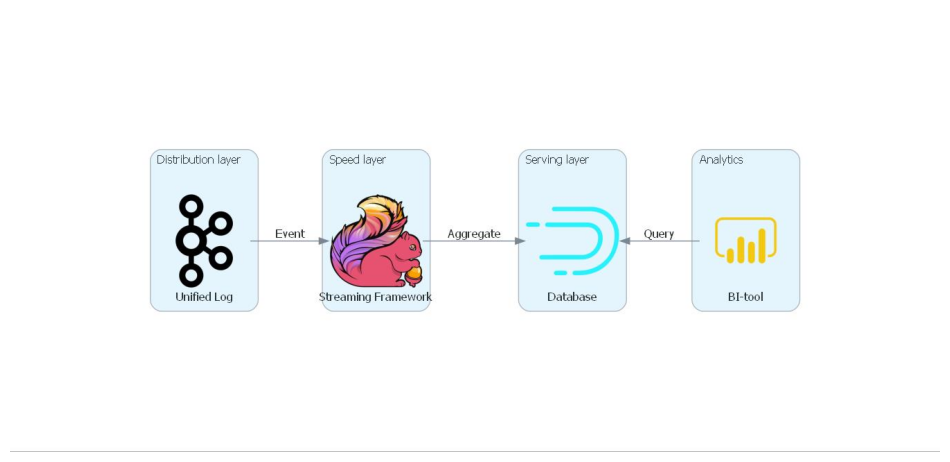

In [4]:
#| label: fig-kappa-tools
#| fig-cap: "Инструменты для реализации Kappa-архитектуры"
from diagrams import Diagram, Cluster, Edge
from diagrams.onprem.queue import Kafka
from diagrams.onprem.analytics import Flink
from diagrams.onprem.database import Druid
from diagrams.onprem.analytics import Powerbi


filename = TEMP_DIR + "kappa-tools"

with Diagram("", show=False, direction="LR", filename=filename, outformat=FORMAT, curvestyle="ortho"):
  with Cluster("Distribution layer", direction="LR"):
    unified_log = Kafka("Unified Log")
  with Cluster("Speed layer", direction="LR"):
    streaming_framework = Flink("Streaming Framework")
  with Cluster("Serving layer", direction="LR"):
    db = Druid("Database")
  unified_log >> Edge(label="Event") >> streaming_framework
  streaming_framework >> Edge(label="Aggregate") >> db
  with Cluster("Analytics", direction="LR"):
    bi = Powerbi("BI-tool")
    db << Edge(label="Query") << bi

show_image(f"{filename}.{FORMAT}", (12, 6))

### 1. Distribution Layer
Это пожалуй единственный уровень, где мы лишены выбора, ведь технология Apache Kafka стала уже дефакто стандартом индустрии для доставки сообщений от производителей к потребителям.

Apache Kafka - это распределенная платформа для потоковой обработки и передачи данных. Она позволяет эффективно передавать потоки данных, обеспечивая устойчивость и масштабируемость, её ключевые особенности:

- Сообщения хранятся в именованных топиках, каждый из которых состоит из одной и более партиций, обеспечивающих горизонтальное масштабирование;
- В рамках партиции порядок сообщений гарантирован, но не в рамках топика;
- Сообщения не удаляются после обработки - они продолжают храниться, благодаря чему одно и то же сообщение может быть обработано сколько угодно раз разными консьюмерами и в разных контекстах.

Типичные кейсы использования Apache Kafka: 

### 2. Speed Layer

#### Apache Flink
Apache Flink — это платформа распределенной обработки данных, его ключевые особенности:

- Использование состояния (Stateful-потоки обработки данных);
- Поддержка фильтрации, агрегации, группировки, оконных функций и соединения потоков данных;
- Истинно стриминговый фреймворк, что позволяет достичь высокой пропускной способности с низкой задержкой;
- Гарантия семантики "только один раз";
- Восстановление после сбоя с нулевой потерей данных засчет механизма снимков состояния
- Можно писать потоки обработки данных на Java и Python/PyFlink;
- Поддержка пакетного режима;
- Источники и приемники данных: Apache Kafka, Apache Cassandra, Amazon Kinesis, Apache HBase, HDFS.

Наиболее частые кейсы использования Apache Flink: обогащение, преобразование и мониторинг потоковых данных

#### Apache Spark

Apache Spark имеет специальный для стриминга компонент - Spark Streaming, который имеет следующие особенности:

- Микробатчинговый стриминг, то есть сначала происходит накопление микробатча данных за некоторый интервал времени (от 500мс до нескольких секунд), а затем их обработка;
- Поддержка фильтрации, агрегации, группировки, оконных функций и соединения потоков данных;
- Восстановление после сбоя и возобновление работы с последней контрольной точки;
- Гарантия семантики "только один раз";
- Можно писать потоки обработки данных на Java и Python/PySpark;
- Изначальное Apache Spark предназначен для пакетного режима;
- Источники и приемники данных: Apache Kafka, Apache Cassandra, HDFS, OpenStack Swift, Amazon S3, Kudu.

#### Другие инструменты
- Apache Kafka Streams;
- Apache Storm;
- Samza;
- Google Cloud Dataflow;
- Azure Stream Analytics.

### 3. Serving Layer

На самом деле на это уровне можно использовать любое хранилище для хранение агрегированных/преобразованных данных для последующей аналитики

#### Apache Druid

Apache Druid это распределенная колоночная timeseries OLAP-система, работающая на следующих принципах:

- Наличие метки времени в каждой строке данных - timestamp, который монотонно растёт;
- Данные только добавляются, не меняются;
- Данные нарезаются на сегменты, вычисления над которыми могут выполняться параллельно.

#### Другие инструменты
- Apache Kudu;
- RDBMS (PostgreSQL, MySQL, ...);
- HDFS;
- S3-подобные системы.

## Приближение к реальности
На рисунке @fig-real-kappa-tools изображена та же архитектура с недостающими важными компонентами.

Так как мы живем в распределенной системе, то нужен координатор, таковым на схеме является Apache Zokeeper.

Для Speed Layer добавились:

- Amazon S3 для хранения ключевых точек и восстановления Apche Flink после сбоя;
- Apache Aerospike для хранения текущего состояния Apche Flink.

Для Serving Layer добавились:

- MySQL для хранения метаданных о сегментах;
- HDFS для хранения самих сегментов данных;
- Memcached для использования в качесте кэша.


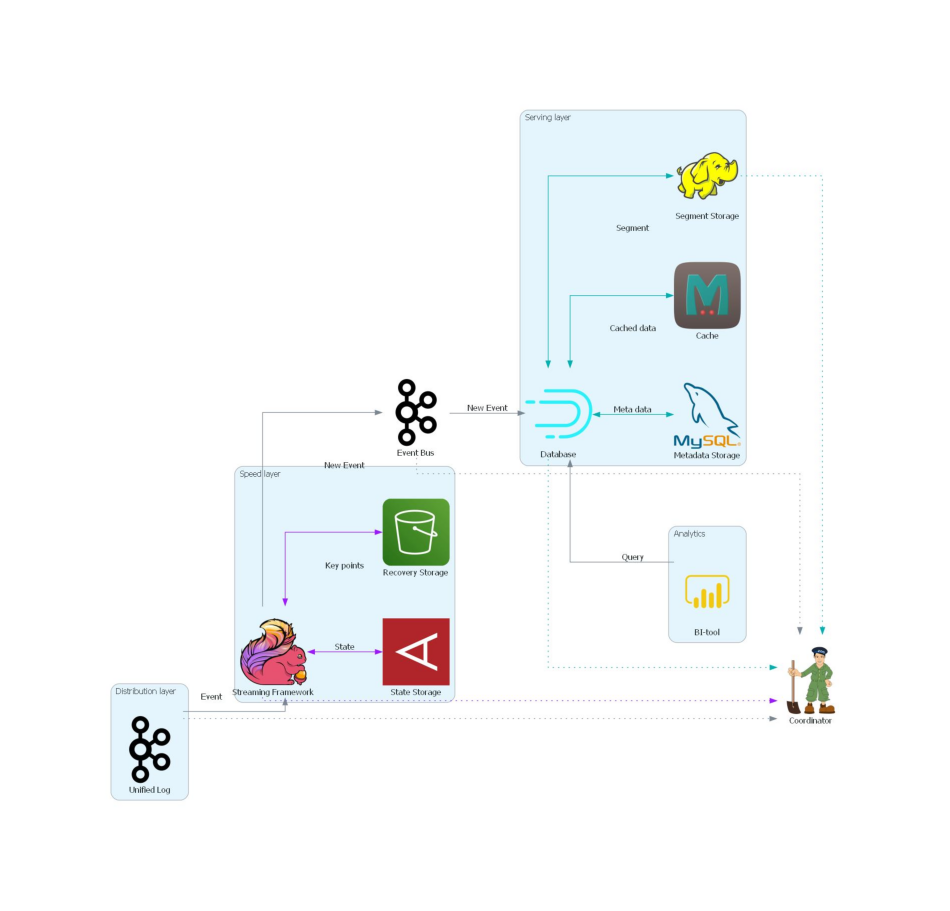

In [5]:
#| label: fig-real-kappa-tools
#| fig-cap: "Инструменты для реализации Kappa-архитектуры"
from diagrams import Diagram, Cluster, Edge
from diagrams.onprem.queue import Kafka
from diagrams.onprem.analytics import Flink
from diagrams.onprem.database import Druid
from diagrams.onprem.analytics import Powerbi
from diagrams.onprem.analytics import Hadoop
from diagrams.onprem.database import Mysql
from diagrams.onprem.inmemory import Memcached
from diagrams.onprem.network import Zookeeper
from diagrams.onprem.inmemory import Aerospike
from diagrams.aws.storage import SimpleStorageServiceS3

filename = TEMP_DIR + "real-kappa-tools"

with Diagram("", show=False, direction="LR", filename=filename, outformat=FORMAT, curvestyle="ortho"):
  coordinator = Zookeeper("Coordinator")
  with Cluster("Distribution layer", direction="LR"):
    unified_log = Kafka("Unified Log")
    unified_log  >> Edge(label="", style="dotted") >> coordinator
  with Cluster("Speed layer", direction="LR"):
    s3 = SimpleStorageServiceS3("Recovery Storage")
    streaming_framework = Flink("Streaming Framework")
    state = Aerospike("State Storage")
    streaming_framework >> Edge(label="State", color="#9E18FF") << state
    streaming_framework >> Edge(label="Key points", color="#9E18FF") << s3
    streaming_framework >> Edge(label="", color="#9E18FF", style="dotted") >> coordinator
  with Cluster("Serving layer", direction="TB"):
    storage = Hadoop("Segment Storage")
    db = Druid("Database")
    meta = Mysql("Metadata Storage")
    cache = Memcached("Cache")
    db >> Edge(label="Meta data", color="#02AFB1") << meta
    db >> Edge(label="Cached data", color="#02AFB1") << cache
    db >> Edge(label="Segment", color="#02AFB1") << storage
    db >> Edge(label="", color="#02AFB1", style="dotted") >> coordinator
    storage >> Edge(label="", color="#02AFB1", style="dotted") >> coordinator
  event_bus = Kafka("Event Bus")
  event_bus  >> Edge(label="", style="dotted") >> coordinator
  unified_log >> Edge(label="Event") >> streaming_framework
  streaming_framework >> Edge(label="New Event") >> event_bus
  event_bus >> Edge(label="New Event") >> db
  with Cluster("Analytics", direction="LR"):
    bi = Powerbi("BI-tool")
    db << Edge(label="Query") << bi

show_image(f"{filename}.{FORMAT}", (12, 12))

## Другие примеры
Архитектура Kappa находит применение в различных отраслях и вариантах использования:

- Аналитика в режиме реального времени;
- Детекция мошеннических операций;
- Обработка данных от IoT-устройств;
- Стриминг логов и событий.